# Machine learning 

#### Importing the ML feeding table

In [1]:
from google.cloud import bigquery
import pandas as pd
from dotenv import load_dotenv
import os
from sklearn.cluster import KMeans
import numpy as np4
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Load environment variables from .env file
load_dotenv()

# Now you can use the environment variable
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")


# Create a BigQuery client
client = bigquery.Client()

# Your BigQuery query
query = """
SELECT * FROM `big-mamma-project.ML_tables.ML_table_6`
"""

# Run the query and convert it to a pandas dataframe
ml = client.query(query,location="EU").to_dataframe()

# Now df is a pandas DataFrame containing the results of the query
ml.drop(columns="order_id",inplace=True)
ml.head(10)

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,card_payment,invoice_payment,cash_payment,...,covers,revenue_per_cover,high_spender,total_main_items,total_starters_items,total_desserts_items,total_beverages_items,total_visits,total_cancellations,total_noshows
0,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>,1,<NA>,<NA>,...,3,36.53,<NA>,6.0,6.0,6.0,11.0,1,<NA>,<NA>
1,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>,...,5,29.04,<NA>,4.0,3.0,0.0,7.0,1,<NA>,<NA>
2,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>,...,5,30.87,<NA>,3.0,3.0,1.0,4.0,<NA>,<NA>,<NA>
3,<NA>,<NA>,<NA>,<NA>,1,<NA>,<NA>,1,<NA>,<NA>,...,5,48.31,<NA>,2.0,4.0,2.0,3.0,<NA>,<NA>,<NA>
4,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>,...,2,30.91,<NA>,2.0,3.0,0.0,7.0,<NA>,<NA>,<NA>
5,<NA>,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>,1,<NA>,...,2,67.58,1,3.0,3.0,0.0,7.0,<NA>,<NA>,<NA>
6,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>,...,5,42.52,<NA>,3.0,6.0,4.0,9.0,1,<NA>,<NA>
7,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,13,52.31,1,0.0,0.0,0.0,19.0,<NA>,<NA>,<NA>
8,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>,1,<NA>,...,2,27.32,<NA>,2.0,1.0,0.0,3.0,<NA>,<NA>,<NA>
9,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>,...,2,36.66,<NA>,2.0,0.0,1.0,1.0,<NA>,<NA>,<NA>


## DF preparation


#### Finding NAs

In [2]:
#Displaying NAs count per column
ml.isnull().sum()

Sunday                   623700
Monday                   646027
Tuesday                  648027
Wednesday                643389
Thursday                 636937
Friday                   627399
Saturday                 611053
card_payment             617871
invoice_payment          205716
cash_payment             714537
DINNER                   327557
LUNCH                    475056
AFTERNOON                687820
actual_duration               0
covers                        0
revenue_per_cover             0
high_spender             622750
total_main_items          24636
total_starters_items      24636
total_desserts_items      24636
total_beverages_items     24636
total_visits              63503
total_cancellations      738977
total_noshows            739189
dtype: int64

In [3]:
ml.dtypes

Sunday                     Int64
Monday                     Int64
Tuesday                    Int64
Wednesday                  Int64
Thursday                   Int64
Friday                     Int64
Saturday                   Int64
card_payment               Int64
invoice_payment            Int64
cash_payment               Int64
DINNER                     Int64
LUNCH                      Int64
AFTERNOON                  Int64
actual_duration            Int64
covers                     Int64
revenue_per_cover        float64
high_spender               Int64
total_main_items         float64
total_starters_items     float64
total_desserts_items     float64
total_beverages_items    float64
total_visits               Int64
total_cancellations        Int64
total_noshows              Int64
dtype: object

#### Fill NAs with 0

In [ ]:
# Fill missing values with the mean of each column
ml = ml.fillna(0)
ml.isnull().sum()

Sunday                   0
Monday                   0
Tuesday                  0
Wednesday                0
Thursday                 0
Friday                   0
Saturday                 0
card_payment             0
invoice_payment          0
cash_payment             0
DINNER                   0
LUNCH                    0
AFTERNOON                0
actual_duration          0
covers                   0
revenue_per_cover        0
high_spender             0
total_main_items         0
total_starters_items     0
total_desserts_items     0
total_beverages_items    0
total_visits             0
total_cancellations      0
total_noshows            0
dtype: int64

#### Removing outliers

In [9]:
import pandas as pd
from scipy import stats


# Select numerical columns only 
numerical_columns = ml.select_dtypes(include=[np.number]).columns

# Calculate Z-scores for each numerical column
z_scores = np.abs((ml[numerical_columns] - ml[numerical_columns].mean()) / ml[numerical_columns].std())

# Define a threshold for outliers (e.g., Z-score > 3, meaning values beyond 3 standard deviations)
threshold = 3

# Create a boolean mask for outliers
outlier_mask = (z_scores > threshold).any(axis=1)

# Remove outliers from the DataFrame
ml_no_outliers = ml[~outlier_mask]

# Keep only the outliers
ml_outliers_only = ml[outlier_mask]


In [13]:
#IQR range method
Q1 = ml[numerical_columns].quantile(0.25)
Q3 = ml[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Create a boolean mask for outliers using the IQR method
outlier_mask_iqr = ((ml[numerical_columns] < (Q1 - 1.5 * IQR)) | (ml[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)

# Remove outliers from the DataFrame
ml_no_outliers_iqr = ml[~outlier_mask_iqr]

# Optionally, keep a DataFrame containing only the outliers
ml_outliers_only_iqr = ml[outlier_mask_iqr]

In [14]:
ml_outliers_only_iqr.describe()

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,card_payment,invoice_payment,cash_payment,...,covers,revenue_per_cover,high_spender,total_main_items,total_starters_items,total_desserts_items,total_beverages_items,total_visits,total_cancellations,total_noshows
count,739422.0,739422.0,739422.0,739422.0,739422.0,739422.0,739422.0,739422.0,739422.0,739422.0,...,739422.0,739422.000000,739422.0,739422.000000,739422.000000,739422.000000,739422.000000,739422.0,739422.0,739422.0
mean,0.156503,0.126308,0.123603,0.129876,0.138602,0.151501,0.173607,0.164387,0.721788,0.033655,...,6.211974,37.320521,0.157788,2.372257,1.556978,0.852099,3.483087,0.914118,0.000602,0.000315
std,0.363332,0.332197,0.329129,0.336167,0.34553,0.358537,0.378772,0.370626,0.448119,0.180339,...,1711.792468,24.146371,0.364542,1.769390,1.667153,1.319298,3.463193,0.28019,0.024525,0.017749
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-0.010000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,25.880000,0.0,1.000000,0.000000,0.000000,2.000000,1.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,34.020000,0.0,2.000000,1.000000,0.000000,3.000000,1.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.0,43.960000,0.0,3.000000,2.000000,1.000000,4.000000,1.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,999999.0,2007.330000,1.0,67.000000,71.000000,44.000000,304.000000,1.0,1.0,1.0


In [15]:
ml_outliers_only.describe()

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,card_payment,invoice_payment,cash_payment,...,covers,revenue_per_cover,high_spender,total_main_items,total_starters_items,total_desserts_items,total_beverages_items,total_visits,total_cancellations,total_noshows
count,165217.0,165217.0,165217.0,165217.0,165217.0,165217.0,165217.0,165217.0,165217.0,165217.0,...,165217.0,165217.000000,165217.0,165217.000000,165217.000000,165217.000000,165217.000000,165217.0,165217.0,165217.0
mean,0.159124,0.119031,0.116296,0.124176,0.139471,0.162169,0.179733,0.174474,0.56171,0.15062,...,18.260936,42.126267,0.211728,2.954993,1.976177,1.328495,4.956076,0.615639,0.002693,0.00141
std,0.365793,0.323826,0.32058,0.329783,0.346439,0.368606,0.383966,0.379517,0.496179,0.357679,...,3621.320308,43.192930,0.408534,2.791557,2.466540,2.077024,5.613131,0.486445,0.051828,0.037527
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-0.010000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,26.110000,0.0,1.000000,0.000000,0.000000,2.000000,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,34.980000,0.0,2.000000,1.000000,1.000000,3.000000,1.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,4.0,47.020000,0.0,4.000000,3.000000,2.000000,6.000000,1.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,999999.0,2007.330000,1.0,67.000000,71.000000,44.000000,304.000000,1.0,1.0,1.0


#### Correlation check and heatmap

Text(0.5, 1.0, 'Correlation Heatmap')

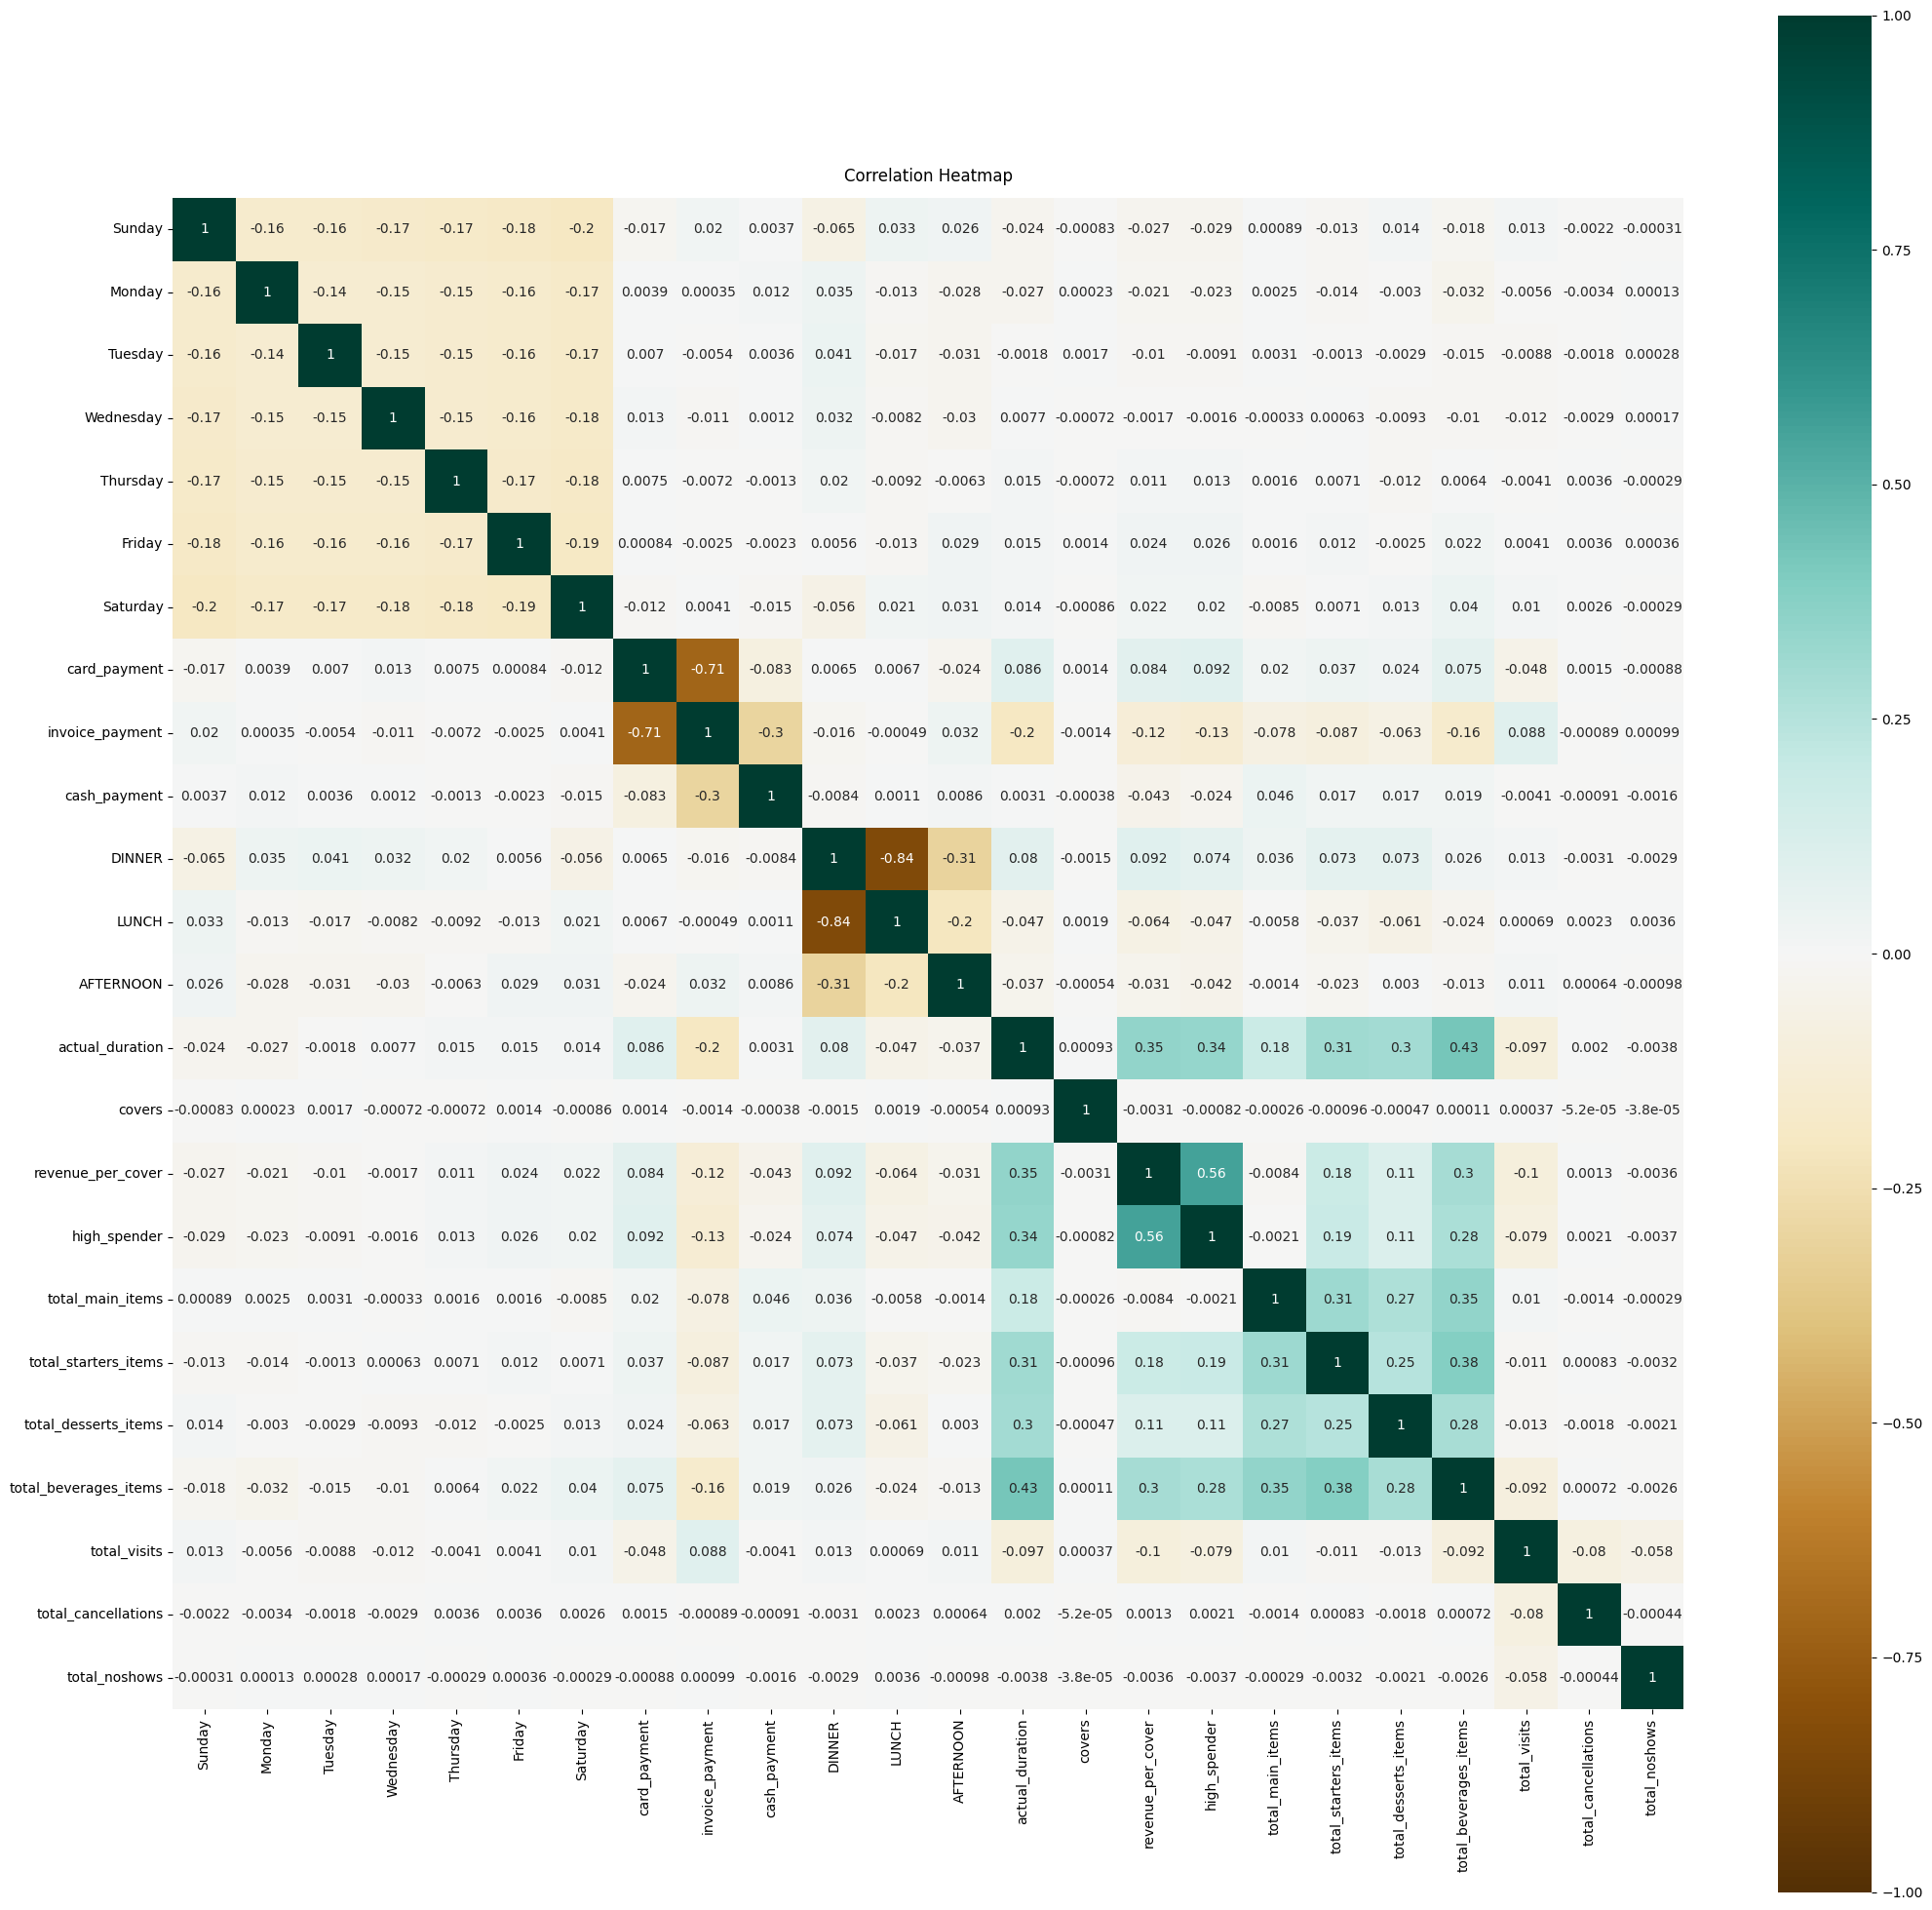

In [16]:
# Increase the size of the heatmap.
plt.figure(figsize=(25,25))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(ml.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG',square=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
# plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Triangle Correlation Heatmap')

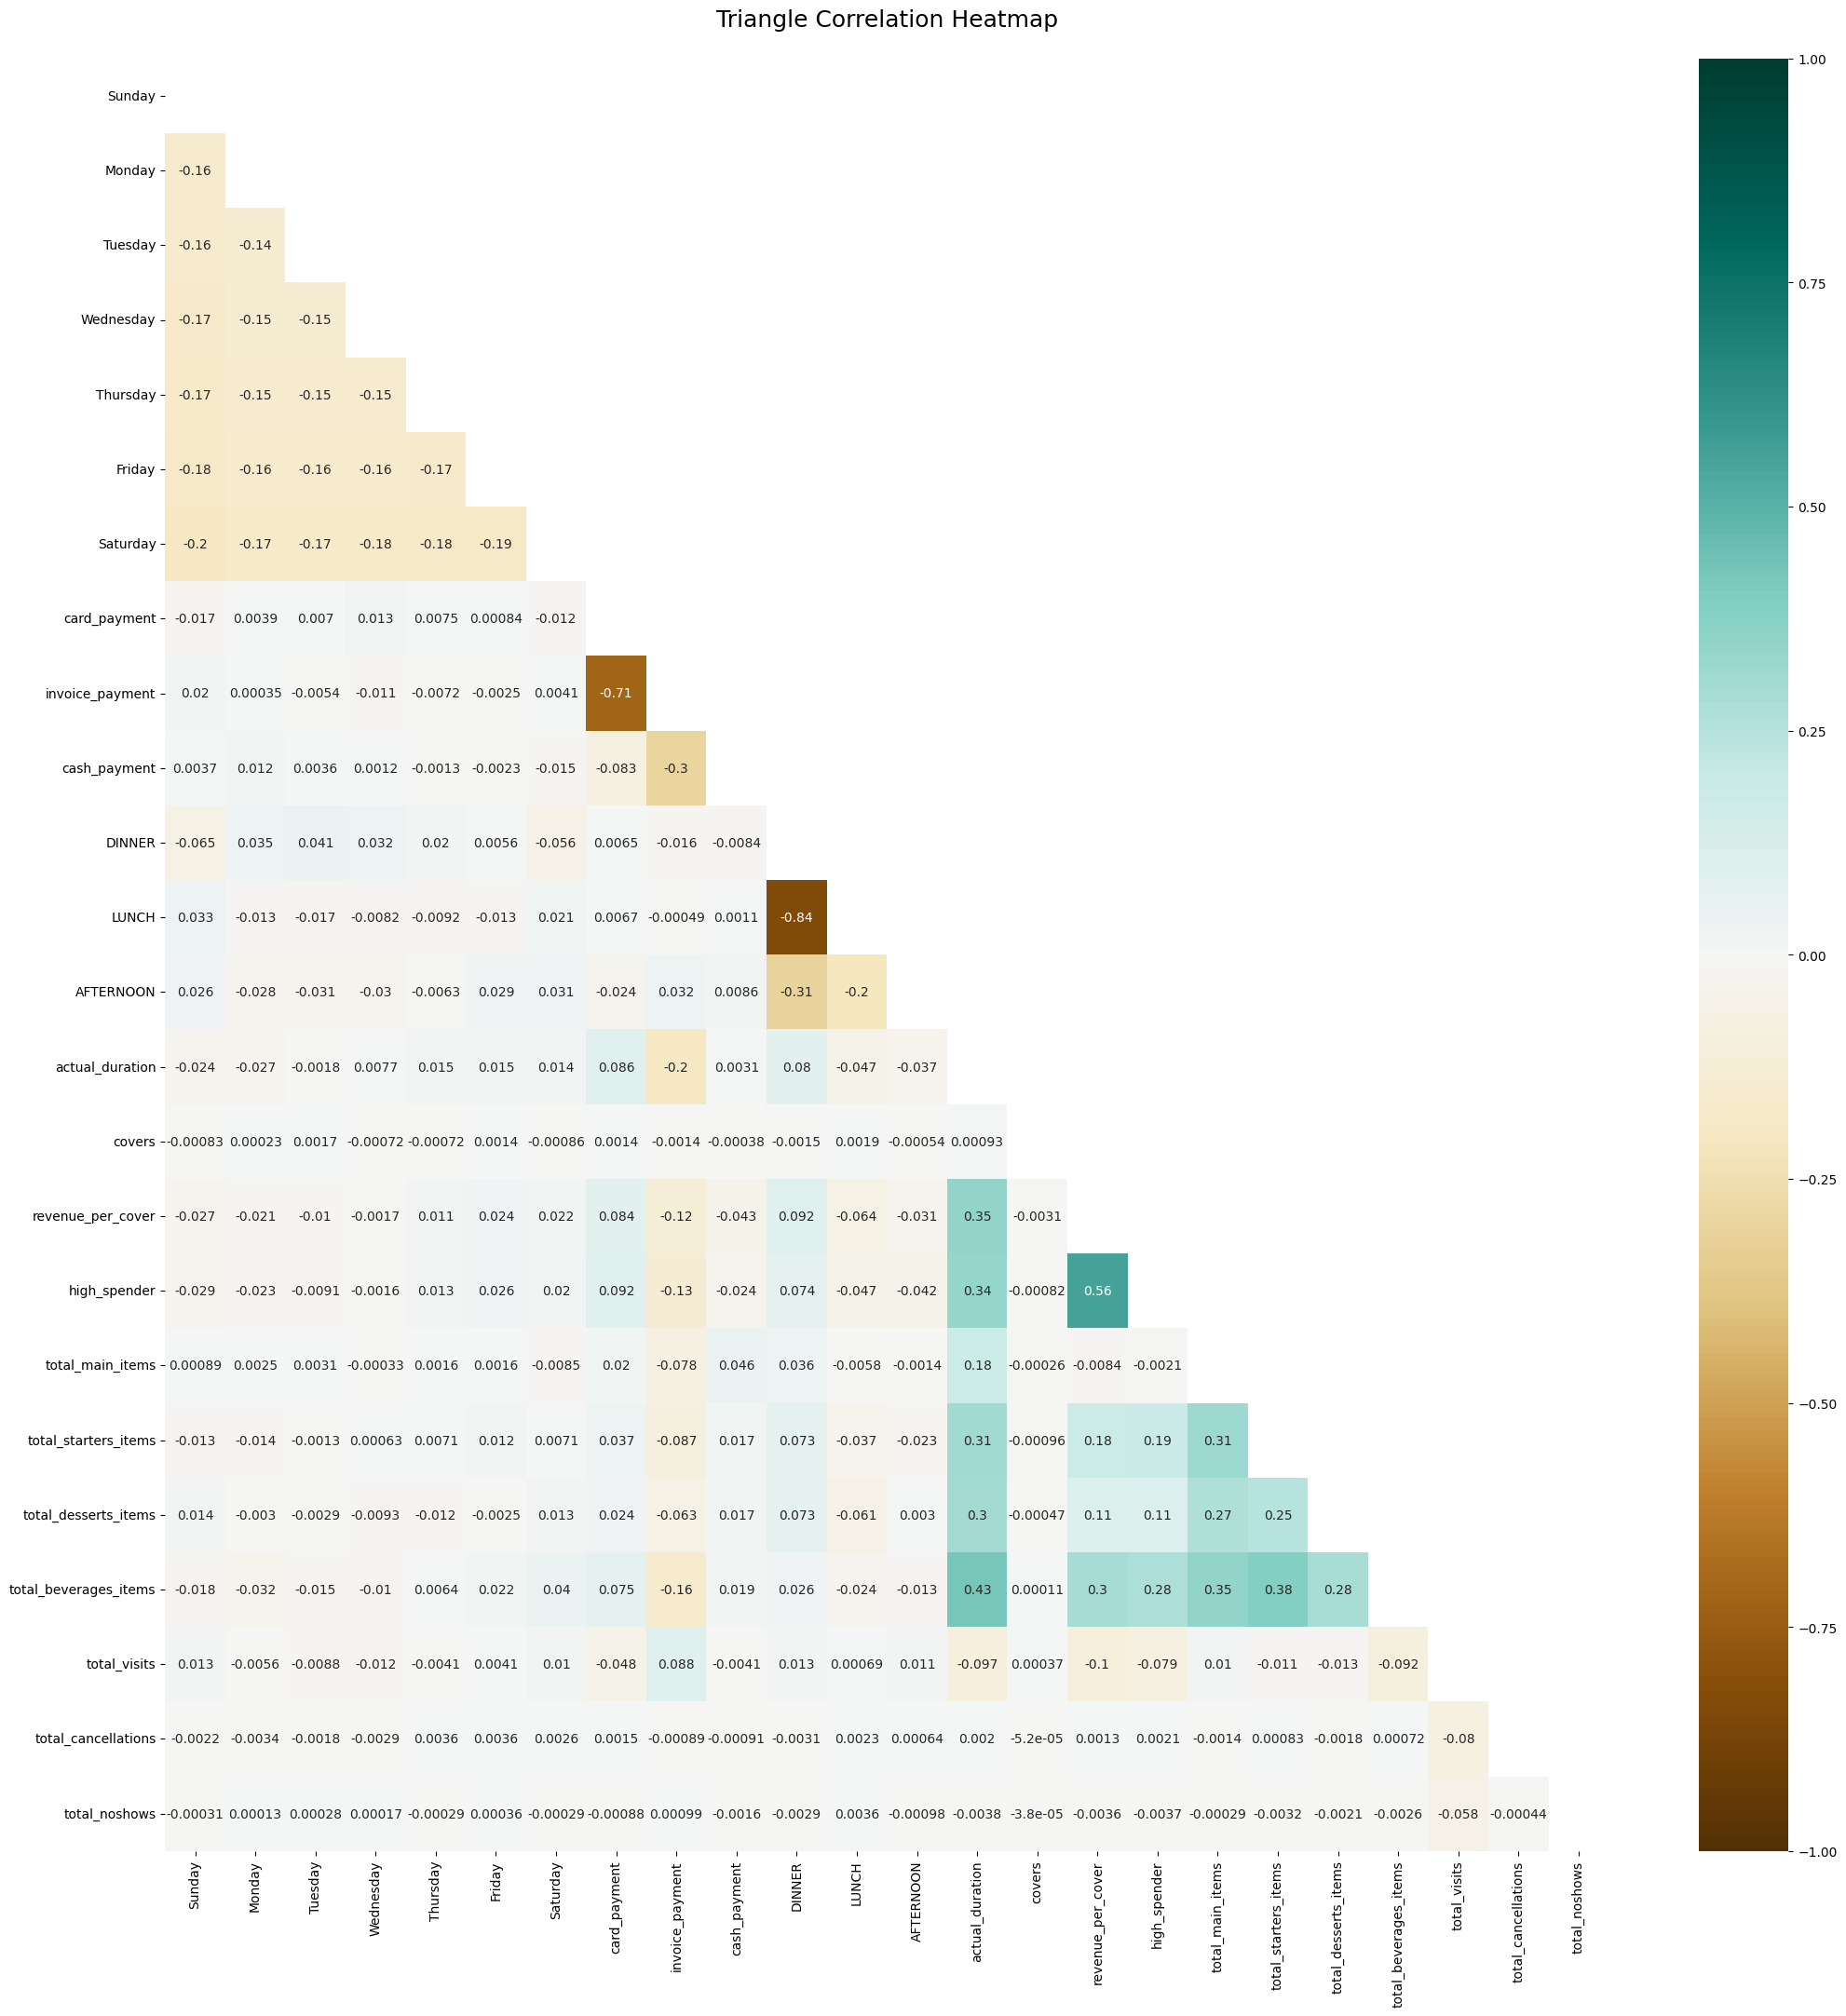

In [17]:
plt.figure(figsize=(25,25))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(ml.corr(), dtype=bool))
heatmap = sns.heatmap(ml.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=25)

#### Distribution check

In [ ]:
ml_distribution = pd.DataFrame(ml.sum(axis=0))
ml_distribution.rename(columns={0:'count'},inplace=True)
ml_distribution['percent'] = round((ml_distribution['count']/len(ml))*100,2)
ml_distribution.sort_values(by='percent',ascending=True)

#### Scaling features


In [18]:
#Scaling the ML table and storing the output 
#Initializing and training scaler 
scaler=StandardScaler()
ml_scaled=scaler.fit_transform(ml)


In [19]:
#Checking our scaled features 
ml_scaled_df=pd.DataFrame(ml_scaled,columns=scaler.get_feature_names_out())
ml_scaled_df

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,card_payment,invoice_payment,cash_payment,...,covers,revenue_per_cover,high_spender,total_main_items,total_starters_items,total_desserts_items,total_beverages_items,total_visits,total_cancellations,total_noshows
0,-0.430745,-0.380221,-0.375547,2.588371,-0.401127,-0.422553,-0.458343,2.254601,-1.610709,-0.186619,...,-0.001876,-0.032739,-0.432839,2.050280,2.665037,3.902004,2.170517,0.306514,-0.024539,-0.017754
1,-0.430745,2.630047,-0.375547,-0.386343,-0.401127,-0.422553,-0.458343,-0.443538,0.620845,-0.186619,...,-0.000708,-0.342930,-0.432839,0.919947,0.865561,-0.645874,1.015512,0.306514,-0.024539,-0.017754
2,-0.430745,-0.380221,2.662780,-0.386343,-0.401127,-0.422553,-0.458343,-0.443538,0.620845,-0.186619,...,-0.000708,-0.267143,-0.432839,0.354780,0.865561,0.112106,0.149259,-3.262498,-0.024539,-0.017754
3,-0.430745,-0.380221,-0.375547,-0.386343,2.492976,-0.422553,-0.458343,2.254601,-1.610709,-0.186619,...,-0.000708,0.455120,-0.432839,-0.210387,1.465386,0.870085,-0.139492,-3.262498,-0.024539,-0.017754
4,-0.430745,-0.380221,2.662780,-0.386343,-0.401127,-0.422553,-0.458343,-0.443538,0.620845,-0.186619,...,-0.002461,-0.265486,-0.432839,-0.210387,0.865561,-0.645874,1.015512,-3.262498,-0.024539,-0.017754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739417,2.321560,-0.380221,-0.375547,-0.386343,-0.401127,-0.422553,-0.458343,-0.443538,0.620845,-0.186619,...,-0.001876,-0.855223,-0.432839,3.745781,0.865561,1.628065,-1.005745,0.306514,-0.024539,-0.017754
739418,2.321560,-0.380221,-0.375547,-0.386343,-0.401127,-0.422553,-0.458343,-0.443538,0.620845,-0.186619,...,-0.000124,-0.563254,-0.432839,0.919947,0.865561,-0.645874,-0.139492,0.306514,-0.024539,-0.017754
739419,-0.430745,-0.380221,-0.375547,-0.386343,2.492976,-0.422553,-0.458343,-0.443538,0.620845,-0.186619,...,-0.002461,-0.126335,-0.432839,-0.210387,-0.334090,0.870085,-0.428243,0.306514,-0.024539,-0.017754
739420,-0.430745,-0.380221,2.662780,-0.386343,-0.401127,-0.422553,-0.458343,-0.443538,-1.610709,-0.186619,...,-0.002461,0.498604,-0.432839,-0.210387,0.865561,0.112106,1.304264,0.306514,-0.024539,-0.017754


# Elbow check to find the proper number of cluster 

#### Elbow method 

In [20]:
#Elbow method
inertias = []
n_k = range(1, 10)

# for each number of centroids
for k in n_k:
     kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(ml_scaled)
     inertias.append(kmeans.inertia_)
print(inertias )

[17746128.000000156, 16455712.210347164, 15848972.321552148, 14843382.57895937, 14052677.126481153, 13676701.349455815, 13122126.024917817, 12472425.463414082, 11789884.835904924]


In [21]:
#Plotting the inertias
import plotly.express as px 
fig = px.line(inertias)
fig.show()

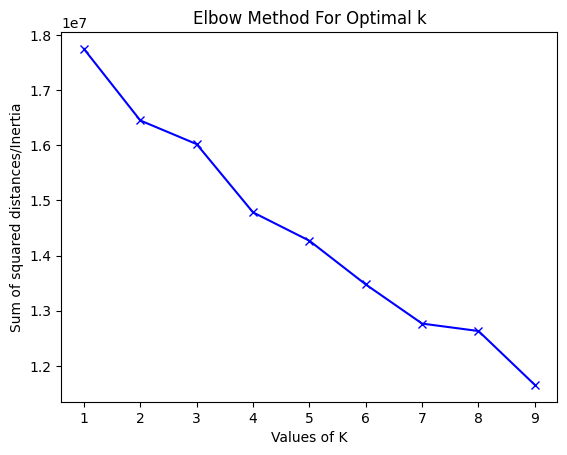

In [23]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters,n_init="auto")
 kmeans.fit(ml_scaled)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

#### Scoring the model via silhouette score

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Fit the K-means model
kmeans = KMeans(n_clusters=3, random_state=15)
cluster_labels = kmeans.fit_predict(ml_scaled)

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(ml_scaled, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

c:\Users\bermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KeyboardInterrupt: 

In [26]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(ml_scaled, cluster_labels)
print(f"Davies-Bouldin Index: {db_index}")

# Calculate Calinski-Harabasz Index
ch_index = calinski_harabasz_score(ml_scaled, cluster_labels)
print(f"Calinski-Harabasz Index: {ch_index}")

Davies-Bouldin Index: 2.7177152615766573
Calinski-Harabasz Index: 52557.6396535978


Davies-Bouldin Index (DBI):

The DBI measures the compactness and separation of clusters. A lower DBI indicates better clustering, where clusters are well-defined and separated.
The index is calculated based on the average similarity between each cluster and its most similar cluster, normalized by the average dissimilarity between the clusters.
A lower DBI is desirable, and the range of values is not bounded.
In your case, a DBI of 2.7177 is relatively good. It suggests that, on average, the clusters are compact and well-separated.

Calinski-Harabasz Index (CHI):

The CHI, also known as the Variance Ratio Criterion, measures the ratio of the between-cluster variance to the within-cluster variance. Higher values indicate better-defined and more separated clusters.
It considers both the distance between cluster centers (numerator) and the spread or dispersion of points within clusters (denominator).
A higher CHI is indicative of better clustering, and the range of values is not bounded.
In your case, a CHI of 52557.6397 is quite high, suggesting that the clusters are well-separated and distinct.

Interpretation:

The combination of a low DBI and a high CHI is generally favorable. It suggests that your clustering algorithm has produced clusters that are both compact and well-separated.

#### First clustering test 

labels
0    155258
1     88406
2    495758
Name: Sunday, dtype: Int64


<Axes: xlabel='labels', ylabel='count'>

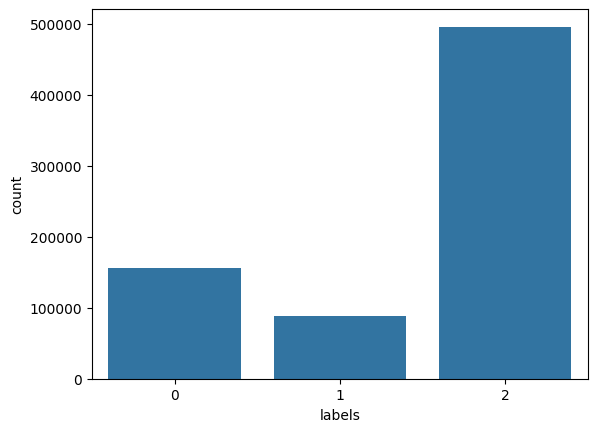

In [27]:
#Lauching clustering prediction
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(ml_scaled)
labels_scaled=kmeans.predict(ml_scaled)

#Applying labels to the original dataframe
ml['labels']=labels_scaled
ml_distrib=ml.groupby('labels',as_index=True)['Sunday'].count()

#Printing number + graph to vizualize 
print(ml_distrib)
sns.countplot(ml,x='labels')

# Exploring results

##### Heatmap

In [28]:
# Analyzing Cluster Results
import matplotlib.pyplot as plt
import seaborn as sns

#Creating heatmap
cm = sns.light_palette("green", as_cmap=True)
#a remettre en ml au lieu de ml_scaled
ml.groupby('labels')[ml.columns[:-1]].mean().style.background_gradient(cmap=cm)

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,card_payment,invoice_payment,cash_payment,DINNER,LUNCH,AFTERNOON,actual_duration,covers,revenue_per_cover,high_spender,total_main_items,total_starters_items,total_desserts_items,total_beverages_items,total_visits,total_cancellations,total_noshows
labels,,,,,,,,,,,,,,,,,,,,,,,,
0,0.143142,0.032134,0.128257,0.140759,0.161460,0.186464,0.207783,0.311333,0.478320,0.035567,0.660359,0.287927,0.044887,126.178245,3.516991,58.900732,0.658156,3.120689,2.819726,1.658974,6.668294,0.853090,0.000812,0.000180
1,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.153067,0.746103,0.038923,0.597245,0.346447,0.052700,80.566421,7.439077,33.899674,0.096283,2.297548,1.365394,0.757844,2.841968,0.916782,0.000351,0.000339
2,0.188596,0.000000,0.144187,0.149627,0.156159,0.167568,0.193863,0.120385,0.793700,0.032116,0.517468,0.381305,0.080632,76.284625,6.837146,31.172205,0.012054,2.151191,1.195684,0.616216,2.599893,0.932755,0.000581,0.000353


#### Scatter plot

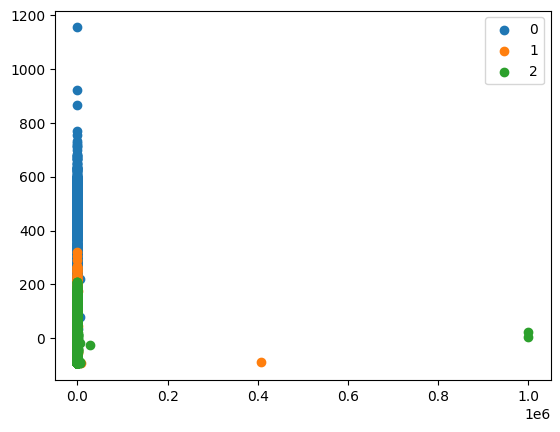

In [29]:
#Importing required modules
 
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

#Transform the data
pca = PCA(2)
ml_results= pca.fit_transform(ml)


#Getting unique labels
u_labels = np.unique(labels_scaled)
 
#plotting the results:
for i in u_labels:
    plt.scatter(ml_results[labels_scaled == i , 0] , ml_results[labels_scaled == i , 1] , label= i)
plt.legend()
plt.show()

In [ ]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(labels_scaled)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(ml_results[labels_scaled == i , 0] , ml_results[labels_scaled == i , 1] , label= i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()